# Fraudsters Model

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.metrics import confusion_matrix

In [2]:
TXN=pd.read_csv("ds_challenge_apr2021.csv")

In [13]:
TXN.head(2)

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,TXN
0,0,F,608.345634,2020-01-21,20,"{'model': 2020, 'device_score': 3, 'os': 'ANDR...",Super,Merida,Física,71000,51,Aceptada,False,60.834563,5.475111,False,1
1,0,F,88.719243,2020-01-15,7,"{'model': 2020, 'device_score': 1, 'os': 'ANDR...",Desconocido,Merida,Virtual,71000,51,Aceptada,False,0.000000,1.774385,False,1


In [57]:
TXN["establecimiento"].unique()

array(['Super', 'Desconocido', 'MPago', 'Abarrotes', 'Farmacia',
       'Restaurante'], dtype=object)

### Feature Engineering
I'll create Customer Variables

In [6]:
TXN["TXN"]=1
# sum: Types of TXN
Approved_TXN=pd.DataFrame(TXN[TXN["status_txn"]=="Aceptada"].groupby("ID_USER")[["TXN","monto","dcto","cashback"]].sum()).reset_index()
Declined_TXN=pd.DataFrame(TXN[TXN["status_txn"]=="Rechazada"].groupby("ID_USER")[["TXN","monto","dcto","cashback"]].sum()).reset_index()
In_Process_TXN=pd.DataFrame(TXN[TXN["status_txn"]=="En proceso"].groupby("ID_USER")[["TXN","monto","dcto","cashback"]].sum()).reset_index()
Fraudulent_TXN=pd.DataFrame(TXN[TXN["fraude"]==True].groupby("ID_USER")[["TXN"]].sum()).reset_index()

In [7]:
# Change the column names
Approved_TXN.columns=["ID_USER","TXN_Aprobadas","Monto_Aprobadas","dcto_Aprobadas",
                      "cashback_Aprobadas"]
Declined_TXN.columns=["ID_USER","TXN_Declinadas","Monto_Declinadas","dcto_Declinadas",
                      "cashback_Declinadas"]
In_Process_TXN.columns=["ID_USER","TXN_En_Proceso","Monto_En_Proceso","dcto_En_Proceso",
                      "cashback_En_Proceso"]
Fraudulent_TXN.columns=["ID_USER","TXN_Fraudulentas"]

In [8]:
# Add the data
Customers=Approved_TXN.merge(Declined_TXN,on="ID_USER",how="outer")
Customers=Customers.merge(In_Process_TXN,on="ID_USER",how="outer")
Customers=Customers.merge(Fraudulent_TXN,on="ID_USER",how="outer")

In [9]:
Customers.head(2)

,ID_USER,TXN_Aprobadas,Monto_Aprobadas,dcto_Aprobadas,cashback_Aprobadas,TXN_Declinadas,Monto_Declinadas,dcto_Declinadas,cashback_Declinadas,TXN_En_Proceso,Monto_En_Proceso,dcto_En_Proceso,cashback_En_Proceso,TXN_Fraudulentas
0,0,2.0,697.064876,60.834563,7.249496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5.0,2589.754665,124.631382,32.857413,1.0,37.003747,0.0,0.370037,1.0,790.037653,0.0,15.800753,NaN


In [10]:
## Replace NaN with 0's
Customers=Customers.fillna(0)

##### Categorical Data
Note: linea_tc is a numerical variable

In [11]:
TXN["ciudad"]=TXN["ciudad"].fillna("Desconocido")
TXN["establecimiento"]=TXN["establecimiento"].fillna("Desconocido")

In [14]:
Establishment_TXN=pd.DataFrame(TXN.groupby("ID_USER")["establecimiento"].apply(lambda x: pd.value_counts(x).index[0])).reset_index()
Type_card_TXN=pd.DataFrame(TXN.groupby("ID_USER")["tipo_tc"].apply(lambda x: pd.value_counts(x).index[0])).reset_index()
Line_Card=pd.DataFrame(TXN.groupby("ID_USER")["linea_tc"].apply(lambda x: pd.value_counts(x).index[0])).reset_index()

##### Add categorical variables to Customer dataset

In [15]:
Customers=Customers.merge(Establishment_TXN,on="ID_USER",how="left")
Customers=Customers.merge(Type_card_TXN,on="ID_USER",how="left")
Customers=Customers.merge(Line_Card,on="ID_USER",how="left")

In [17]:
Customers.head(2)

,ID_USER,TXN_Aprobadas,Monto_Aprobadas,dcto_Aprobadas,cashback_Aprobadas,TXN_Declinadas,Monto_Declinadas,dcto_Declinadas,cashback_Declinadas,TXN_En_Proceso,Monto_En_Proceso,dcto_En_Proceso,cashback_En_Proceso,TXN_Fraudulentas,establecimiento,tipo_tc,linea_tc
0,0,2.0,697.064876,60.834563,7.249496,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,Desconocido,Virtual,71000
1,1,5.0,2589.754665,124.631382,32.857413,1.0,37.003747,0.0,0.370037,1.0,790.037653,0.0,15.800753,0.0,Desconocido,Física,94000


#### OHE Categorical Variables

In [22]:
enc = OneHotEncoder(handle_unknown='ignore')
Categorical_Data=Customers[['establecimiento','tipo_tc']]
Categorical_Data=pd.DataFrame.sparse.from_spmatrix(enc.fit_transform(Categorical_Data))
Categorical_Data.columns=enc.get_feature_names_out(['establecimiento','tipo_tc'])

In [24]:
Customers=pd.concat([Customers,Categorical_Data],axis=1)

In [26]:
Customers["Is_Fraudster"]=np.where(Customers["TXN_Fraudulentas"]>0,1,0)

In [27]:
Customers["Is_Fraudster"].value_counts()

0    3325
1     675
Name: Is_Fraudster, dtype: int64

In [29]:
Customers.columns

Index(['ID_USER', 'TXN_Aprobadas', 'Monto_Aprobadas', 'dcto_Aprobadas',
       'cashback_Aprobadas', 'TXN_Declinadas', 'Monto_Declinadas',
       'dcto_Declinadas', 'cashback_Declinadas', 'TXN_En_Proceso',
       'Monto_En_Proceso', 'dcto_En_Proceso', 'cashback_En_Proceso',
       'TXN_Fraudulentas', 'establecimiento', 'tipo_tc', 'linea_tc',
       'establecimiento_Abarrotes', 'establecimiento_Desconocido',
       'establecimiento_Farmacia', 'establecimiento_MPago',
       'establecimiento_Restaurante', 'establecimiento_Super',
       'tipo_tc_Física', 'tipo_tc_Virtual', 'Is_Fraudster'],
      dtype='object')

In [31]:
Predictive_Variables=['TXN_Aprobadas','TXN_Declinadas','TXN_En_Proceso',
                      'linea_tc',
       'establecimiento_Abarrotes', 'establecimiento_Desconocido',
       'establecimiento_Farmacia', 'establecimiento_MPago',
       'establecimiento_Restaurante', 'establecimiento_Super',
       'tipo_tc_Física', 'tipo_tc_Virtual']

In [33]:
X=Customers[Predictive_Variables]
Y=Customers["Is_Fraudster"]

### Imbalanced dataset
The dataset is unbalanced, so we need to apply a technique in order to balance it. I will use Synthetic Minority Oversampling Technique (SMOTE), which synthetic data for the minority class.

In [28]:
from imblearn.over_sampling import SMOTE

In [35]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X, Y)
# Split the data in training/testing
X_train, X_test, Y_train, Y_test = train_test_split( x_smote, y_smote, 
                                                    test_size=0.2, random_state=40)

## Model

In [40]:
from xgboost import XGBClassifier

In [41]:
model = XGBClassifier()
model.fit(X_train, Y_train)

[12:55:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Testing the model

In [42]:
Y_train_pred=model.predict(X_train)
Y_test_pred=model.predict(X_test)
print("Accuracy Training Data: ", accuracy_score(Y_train,Y_train_pred))
print("Accuracy Testing Data: ", accuracy_score(Y_test,Y_test_pred))
print("Classification error in Testing Data")
print(classification_report(Y_test,Y_test_pred))

Accuracy Training Data:  0.9518796992481203
Accuracy Testing Data:  0.8849624060150376
Classification error in Testing Data
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       684
           1       0.92      0.84      0.88       646

    accuracy                           0.88      1330
   macro avg       0.89      0.88      0.88      1330
weighted avg       0.89      0.88      0.88      1330



#### Feature Importance

In [43]:
from xgboost import plot_importance

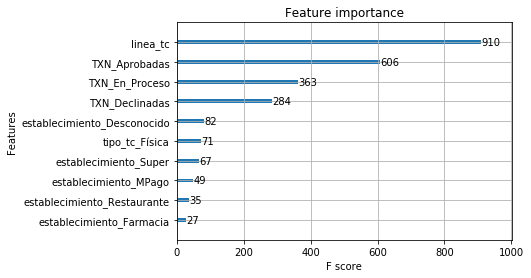

In [62]:
plot_importance(model,max_num_features=10)
plt.show()

In [71]:
Customers.groupby("Is_Fraudster")[["linea_tc","TXN_Aprobadas","TXN_En_Proceso",
                                  "TXN_Declinadas","establecimiento_Desconocido"]].mean()

,linea_tc,TXN_Aprobadas,TXN_En_Proceso,TXN_Declinadas,establecimiento_Desconocido
Is_Fraudster,,,,,
0,62531.428571,4.012632,1.163308,0.593383,0.576842
1,61448.888889,8.151111,2.182222,1.210370,0.675556


In [48]:
model.save_model('Fraudsters_Model.model')

In [52]:
import pickle

In [56]:
pd.Series(model.predict(X_test)).value_counts()

0    737
1    593
dtype: int64

In [53]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))